# Reference : https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py

In [5]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr) * self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (
                        1 + math.cos(math.pi * (self.T_cur - self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma ** self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            if lr <= self.base_lrs[0]:
                param_group['lr'] = self.base_lrs[0]
            else:
                param_group['lr'] = lr

In [2]:
import torch
model = torch.nn.Linear(3,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=2, eta_max=0.1, T_up=10, gamma=0.3, last_epoch=-1)
lrs = []
for _ in range(1000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

import matplotlib.pyplot as plt
plt.plot(range(len(lrs)), lrs)

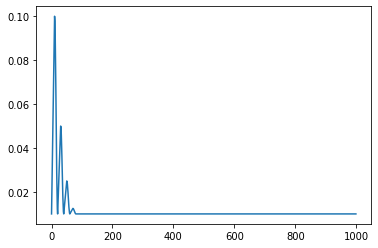

In [6]:
import torch
model = torch.nn.Linear(3,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=20, T_mult=1, eta_max=0.1, T_up=10, gamma=0.5, last_epoch=-1)
lrs = []
for _ in range(1000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

import matplotlib.pyplot as plt
plt.plot(range(len(lrs)), lrs)

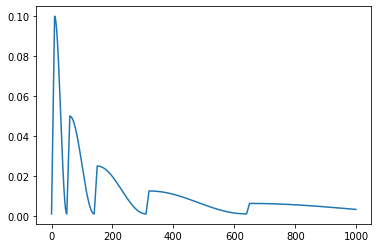

In [16]:
import torch
model = torch.nn.Linear(3,3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=2, eta_max=0.1, T_up=10, gamma=0.5, last_epoch=-1)
lrs = []
for _ in range(1000):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

import matplotlib.pyplot as plt
plt.plot(range(len(lrs)), lrs)